### 눈동자 추출
---
- mkdir -p ~/aiffel/coarse_to_fine/images
  
- wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P ~/aiffel/coarse_to_fine/models/
- cd ~/aiffel/coarse_to_fine/models/ && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib

(437, 700, 3)


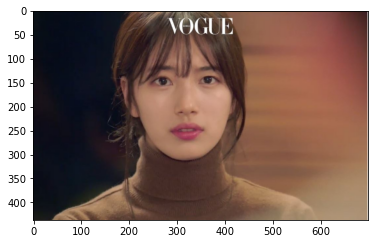

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/images/face.png'
img = cv2.imread(img_path)
print (img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

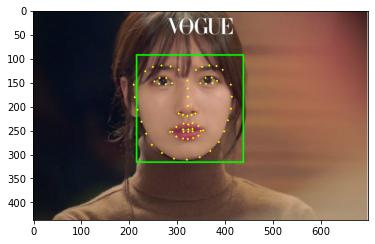

In [3]:
img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_model_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(dlib_model_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_rgb)
plt.show()

In [4]:
def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()
    
    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl
    
    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6
    
    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

(25, 43, 3)


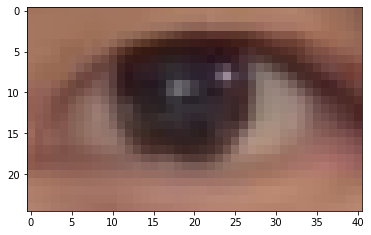

In [5]:
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape)
plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
plt.show()

[OpenCV 영상 화질 향상 기법 #5 - Bilateral Filter](http://egloos.zum.com/eyes33/v/6092269)
- 1차원 값으로 누적시킨 후 y 축 기준으로 최대값을 찾아서 center_y 좌표를 먼저 얻어냅니다. (y 축은 x 축에 비해 상대적으로 변화가 적기 때문에 간단하게 구현할 수 있습니다)

- x축은 1차원 max point를 기준으로 mean shift를 수행합니다. 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력합니다.

In [6]:
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]

    # smoothing
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1
    
    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1
    
    return [center_x, center_y]

In [7]:
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

In [8]:
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

(19, 9) (16, 8) (25, 43) (25, 41)


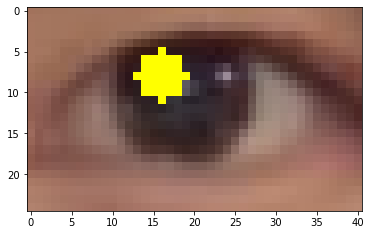

In [9]:
show = img_right_eye.copy()
    
show = cv2.circle(show, (right_center_x, right_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

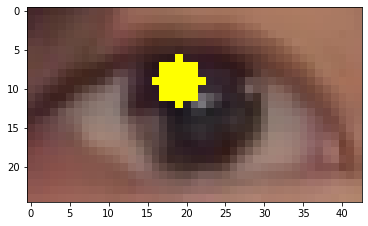

In [10]:
show = img_left_eye.copy()
    
show = cv2.circle(show, (left_center_x, left_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

[[기계 학습] Mean Shift 클러스터링](https://bab2min.tistory.com/637)

#### 키포인트 검출 딥러닝 모델 만들기  

![이미지](https://aiffelstaticprd.blob.core.windows.net/media/images/gc-8-l-cuga4.max-800x600.png)  
1. 기본 ResNet 모델을 구현
2. ImageNet 데이터셋으로 pretraining
3. ResNet의 fully connected layer 를 수정하고 회귀 손실 함수를 구현하여 눈동자 위치를 학습  
  
- pip install tensorflow_hub

In [11]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

Resnet에서 사용하고 있는 residual block의 종류는 몇 가지인가요?

1) 3x3 conv 2개의 일반 residual block, 2) 1x1 conv를 이용한 bottleneck 구조

ResNet이 VGG보다 성능이 좋은 이유는 무엇일까요?

skip connection을 통해 불필요한 파라미터를 줄일 수 있는 효과를 얻음. 불필요한 파라미터인지도 직접 학습할 수 있는 end-to-end 구조와 skip connection, 3x3 conv 의 앙상블 효과가 성능에 긍정적인 영향을 미침

Fine tuning을 할 때는 모델의 입력을 특히 주의해야 합니다. 입력 크기의 차이가 많은 경우 pooling 후 크기가 유효하지 않을 수 있어서 모델이 아예 동작하지 않을 수 있습니다. 모델 설명 페이지에서는 이 문장을 반드시 찾아야합니다. 우리의 경우 다음과 같습니다.

In [12]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(80,120,3))

In [13]:
num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


#### 라벨링 툴
- [OpenCV/cvat](https://github.com/openvinotoolkit/cvat)
- [COCO Dataset](https://cocodataset.org/#home)
- [NaturalIntelligence/imglab](https://github.com/NaturalIntelligence/imglab)
- [labelimg](https://github.com/tzutalin/labelImg)
- [labelme](https://github.com/wkentaro/labelme) 
  
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/my_labeler_1st.py -P ~/aiffel/coarse_to_fine

CAM의 계산 방법을 설명

CNN을 통과한 logit을 GAP해서 채널 수 별로 embedding 합니다. embedding layer에 클래스 개수만큼 fully connected layer를 통과시킵니다. 이 때 FC layer의 weight과 logit의 가중합을 계산하면 CAM을 얻을 수 있습니다.

![이미지2](https://aiffelstaticprd.blob.core.windows.net/media/images/05_5gBiwDe.max-800x600.png)